In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
! pip install xgboost
#Documentation for GPU: https://xgboost.readthedocs.io/en/latest/gpu/index.html#

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
## Importing libraries
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
import os
from keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import img_to_array 


In [4]:
print(os.listdir("/content/gdrive/MyDrive/dataset"))

SIZE = 256 

['image', 'mask']


In [5]:
# Capture training images and convert to numpy array
training_images = glob.glob("/content/gdrive/MyDrive/dataset/image/*.tif")
training_images.sort()

images = [cv2.imread(image, 1) for image in training_images] 
image_dataset = np.array(images)
#image_dataset = np.expand_dims(image_dataset, axis = 3)

In [6]:
# Capture training images, sorting and converting to numpy array
training_mask = glob.glob("/content/gdrive/MyDrive/dataset/mask/*.tif")
training_mask.sort()

masks = [cv2.imread(mask, 0) for mask in training_mask]
mask_dataset = np.array(masks)

In [7]:
print("Total images in the original dataset are: ", len(training_images))
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Total images in the original dataset are:  20
Image data shape is:  (20, 256, 256, 3)
Mask data shape is:  (20, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1]


In [8]:
#label encoding
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1])

In [9]:
#Normalize images
image_dataset = image_dataset /255.

In [10]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [11]:
#Load VGG16 model without classifier/fully connected layers
#Load imagenet weights for extracting features
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))


#We are not using any trainable layers here.....just using pretrained weights
for layer in VGG_model.layers:
	layer.trainable = False

# No trainable parameters(important)    
VGG_model.summary()  

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [12]:
# Extract only 2 conv layers/blocks
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [13]:
# Extract features from convolutional layers
features = new_model.predict(X_train)

1/1 [==============================] - 7s 7s/step


In [14]:
#Reassign 'features' as X 
X=features

# Reshape X to match with labels that can be used for XGBoost model

X = X.reshape(-1, X.shape[3])  

print(X.shape)

(1048576, 64)


In [15]:
#Reshape Y to match X
Y = y_train.reshape(-1)
print(Y.shape)

(1048576,)


In [16]:
np.unique(Y)

array([0, 1])

In [17]:
#XGBOOST

import xgboost as xgb

model = xgb.XGBClassifier(learning_rate=0.5,n_estimators=100, max_depth=3)  

#Define gpu_id, otherwise it uses CPU and would take longer
#model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)


In [18]:
# Train the model on training data. I used default parameters
model.fit(X, Y)

XGBClassifier(learning_rate=0.5)

In [ ]:
#Can try fine tuning it.
#XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              #colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              #learning_rate=0.1, max_delta_step=0, max_depth=3,
              #min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              #nthread=None, objective='multi:softprob', random_state=0,
              #reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              #silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [23]:
#Save model for future use

filename = '/content/gdrive/MyDrive/Agroforestry/agro_XGB.sav'

In [24]:
pickle.dump(model, open(filename, 'wb'))

In [25]:
#Load model
loaded_model = pickle.load(open(filename, 'rb'))

In [26]:
X_test_features=new_model.predict(X_test)
X_test_features=X_test_features.reshape(-1, X_test_features.shape[3])
print(X_test_features.shape)

1/1 [==============================] - 0s 297ms/step
(262144, 64)


In [27]:
# Predict using trained XGB model
y_pred = loaded_model.predict(X_test_features)
print(y_pred.shape)

(262144,)


In [28]:
test_labels = y_test.reshape(-1)
print(test_labels.shape)

(262144,)


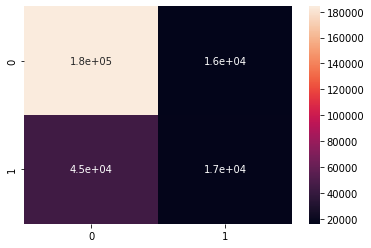

In [29]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, y_pred)
#print(cm)
sns.heatmap(cm, annot=True)

In [30]:
#Print overall accuracy not just pixel accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, y_pred))

Accuracy =  0.7687149047851562


In [31]:
#IOU(Intersection over Union)
from keras.metrics import MeanIoU

#Using built in keras function

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_labels, y_pred)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.48766723


1/1 [==============================] - 0s 140ms/step


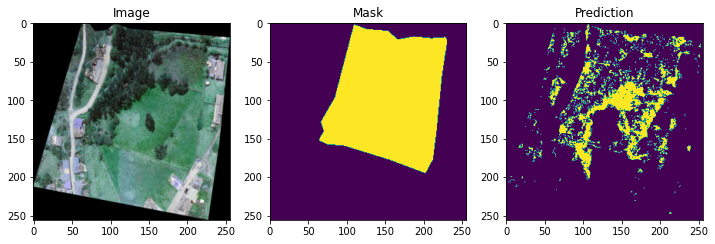

In [32]:
import random
img_number = random.randint(0, len(X_test)-1)
img = X_test[img_number]
img=np.expand_dims(img, axis=0)

img_features=new_model.predict(img)
img_features = img_features.reshape(-1, img_features.shape[3])
mask = y_test[img_number]

prediction = loaded_model.predict(img_features)
predicted_mask = prediction.reshape(mask.shape[0], mask.shape[1])

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img[0], cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask)
plt.subplot(233)
plt.title('Prediction')
plt.imshow(predicted_mask)
plt.show()

1/1 [==============================] - 0s 18ms/step


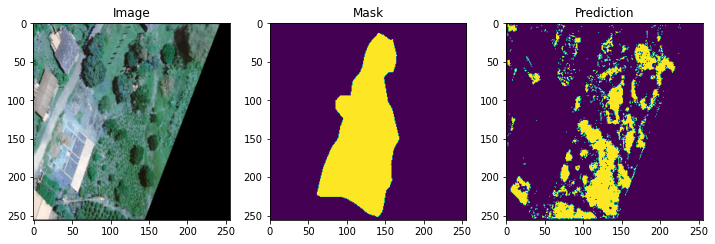

In [40]:
img_number = random.randint(0, len(X_test)-1)
img = X_test[img_number]
img=np.expand_dims(img, axis=0)

img_features=new_model.predict(img)
img_features = img_features.reshape(-1, img_features.shape[3])
mask = y_test[img_number]

prediction = loaded_model.predict(img_features)
predicted_mask = prediction.reshape(mask.shape[0], mask.shape[1])

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img[0], cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask)
plt.subplot(233)
plt.title('Prediction')
plt.imshow(predicted_mask)
plt.show()